In [ ]:
# Step 1: Imports and Setup

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import resnet34, ResNet34_Weights
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os, json
from PIL import Image
import numpy as np



In [ ]:
# Step 2: Load Pretrained ResNet-34 (on ImageNet-1K)

model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Step 3: Extract the uploaded ZIP file

import zipfile
import os

zip_path = "/content/TestDataSet.zip"
extract_dir = "/content/TestDataSet"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Extracted to {extract_dir}")


✅ Extracted to /content/TestDataSet


In [ ]:
# Step 3: Define ImageNet Normalization (Preprocessing)

mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])


In [ ]:
# Step 4: Load Dataset

dataset_path = "/content/TestDataSet/TestDataSet"

dataset = torchvision.datasets.ImageFolder(
    root=dataset_path,
    transform=plain_transforms
)

data_loader = DataLoader(dataset, batch_size=32, shuffle=False)
print(f"Loaded {len(dataset)} images across {len(dataset.classes)} classes.")


Loaded 500 images across 100 classes.


In [ ]:
with open(os.path.join(dataset_path, "labels_list.json"), "r") as f:
    label_list = json.load(f)

imagenet_indices = [int(entry.split(":")[0]) for entry in label_list]
synset_to_idx = {synset: imagenet_indices[i] for i, synset in enumerate(dataset.classes)}
imagenet_idx_to_label = {int(entry.split(":")[0]): entry.split(":")[1].strip() for entry in label_list}


In [ ]:
# Step 6: Evaluate Top-1 and Top-5 Accuracy

top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for images, targets in tqdm(data_loader):
        images = images.to(device)

        # Map dataset label index (e.g., 0, 1, ...) → ImageNet class index
        true_imagenet_indices = [synset_to_idx[dataset.classes[t]] for t in targets]
        true_imagenet_indices = torch.tensor(true_imagenet_indices).to(device)

        outputs = model(images)
        _, top5_preds = outputs.topk(5, dim=1)

        # Top-1: First prediction matches label
        top1_correct += (top5_preds[:, 0] == true_imagenet_indices).sum().item()

        # Top-5: Any of the top-5 match the label
        for i in range(images.size(0)):
            if true_imagenet_indices[i].item() in top5_preds[i]:
                top5_correct += 1

        total += images.size(0)

top1_acc = top1_correct / total
top5_acc = top5_correct / total

print(f"✅ Top-1 Accuracy: {top1_acc:.4f}")
print(f"✅ Top-5 Accuracy: {top5_acc:.4f}")


100%|██████████| 16/16 [00:01<00:00, 10.97it/s]

✅ Top-1 Accuracy: 0.7600
✅ Top-5 Accuracy: 0.9420


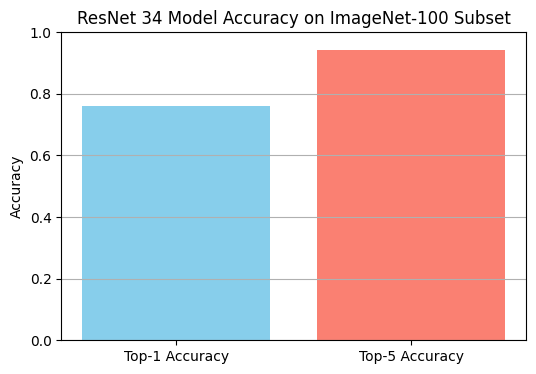

In [ ]:
import matplotlib.pyplot as plt

# Plot top-k accuracy
plt.figure(figsize=(6, 4))
plt.bar(["Top-1 Accuracy", "Top-5 Accuracy"], [top1_acc, top5_acc], color=["skyblue", "salmon"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("ResNet 34 Model Accuracy on ImageNet-100 Subset")
plt.grid(axis='y')
plt.show()


In [ ]:
def show_clean_samples(orig_dataset, model, indices):
    model.eval()
    fig, axs = plt.subplots(len(indices), 1, figsize=(7, 3 * len(indices)))

    for i, idx in enumerate(indices):
        orig_img, _ = orig_dataset[idx]
        input_tensor = orig_img.unsqueeze(0).to(device).float()

        with torch.no_grad():
            pred_idx = model(input_tensor).argmax(dim=1).item()

        if pred_idx in imagenet_idx_to_label:
            label = imagenet_idx_to_label[pred_idx]
        else:
            label = f"Predicted: [Out of subset] Class {pred_idx}"

        axs[i].imshow(torch.clamp(orig_img, 0, 1).permute(1, 2, 0).numpy())
        axs[i].set_title(f"{model.__class__.__name__} Prediction: {label}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


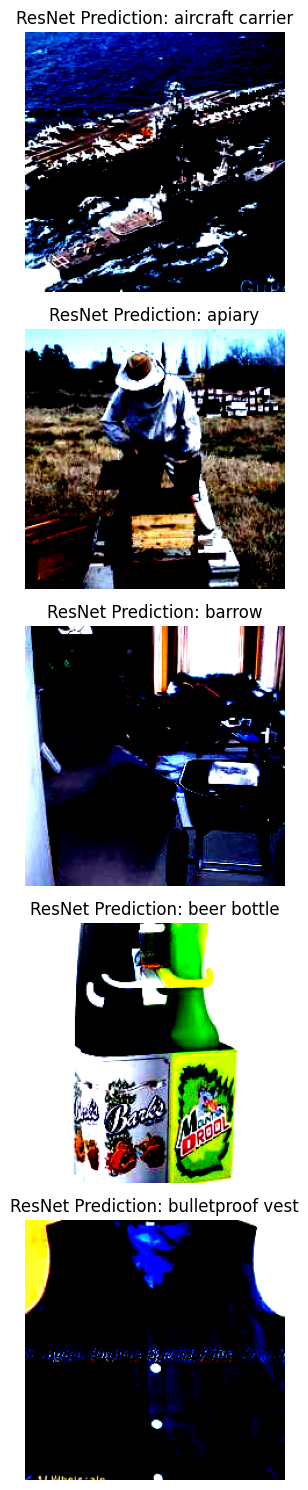

In [ ]:
sample_indices = [10, 49, 139, 197, 321]  # consistent across all tasks
show_clean_samples(dataset, model, sample_indices)


## Task 2

In [ ]:
# Re-declare dataset in pixel space (without normalization)
raw_transforms = transforms.ToTensor()

raw_dataset = torchvision.datasets.ImageFolder(
    root=dataset_path,
    transform=raw_transforms
)

raw_loader = DataLoader(raw_dataset, batch_size=32, shuffle=False)


In [ ]:
# === FGSM Attack ===
def fgsm_attack_raw(model, images, labels, epsilon=0.02):
    images = images.clone().detach().to(device).requires_grad_(True)
    labels = labels.to(device)
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()
    return torch.clamp(images + epsilon * images.grad.sign(), 0, 1)


In [ ]:
# === Generate Adversarial Test Set 1 ===
adv_images_list, adv_labels_list = [], []
for images, labels in raw_loader:
    true_labels = torch.tensor([synset_to_idx[raw_dataset.classes[t]] for t in labels])
    adv_images = fgsm_attack_raw(model, images, true_labels)
    adv_images_list.append(adv_images.cpu())
    adv_labels_list.append(true_labels.cpu())

adv_dataset_images = torch.cat(adv_images_list)
adv_dataset_labels = torch.cat(adv_labels_list)


In [ ]:
# === Verify L∞ Constraint (ε = 0.02) ===
def verify_linf_raw(orig_dataset, adv_tensor, epsilon=0.02, attack_name="FGSM"):
    max_diffs = [
        torch.abs(orig_dataset[i][0] - adv_tensor[i].cpu()).max().item()
        for i in range(len(orig_dataset))
    ]
    max_val = max(max_diffs)
    print(f"🔎 {attack_name} - Max L∞ distance: {max_val:.6f}")

    if max_val <= epsilon + 1e-6:
        print(f"✔️ {attack_name} - ε constraint satisfied\n")
    else:
        print(f"❌ {attack_name} - ε constraint violated\n")


verify_linf_raw(raw_dataset, adv_dataset_images, epsilon=0.02, attack_name="FGSM")


🔎 FGSM - Max L∞ distance: 0.020000
✔️ FGSM - ε constraint satisfied



In [ ]:
# === Evaluate Accuracy on Adversarial Test Set 1 ===
adv_loader = DataLoader(list(zip(adv_dataset_images, adv_dataset_labels)), batch_size=32)
top1, top5, total = 0, 0, 0
with torch.no_grad():
    for images, labels in adv_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, top5_preds = outputs.topk(5, dim=1)
        top1 += (top5_preds[:, 0] == labels).sum().item()
        top5 += sum([labels[i].item() in top5_preds[i] for i in range(images.size(0))])
        total += images.size(0)

print(f"⚠️ FGSM Top-1 Accuracy: {top1 / total:.4f}")
print(f"⚠️ FGSM Top-5 Accuracy: {top5 / total:.4f}")


⚠️ FGSM Top-1 Accuracy: 0.0080
⚠️ FGSM Top-5 Accuracy: 0.0700


In [ ]:
# === Save Dataset ===
torch.save((adv_dataset_images, adv_dataset_labels), "Adversarial_Test_Set_1.pt")

🖼️ Visualize  Adversarial Comparision against original

In [ ]:
def show_adversarial_comparison(orig_dataset, adv_dataset_images, model, indices, attack_name="FGSM"):
    model.eval()
    for idx in indices:
        orig_img, _ = orig_dataset[idx]
        orig_tensor = orig_img.unsqueeze(0).to(device).float()
        adv_tensor = adv_dataset_images[idx].unsqueeze(0).to(device).float()

        with torch.no_grad():
            orig_pred = model(orig_tensor).argmax(dim=1).item()
            adv_pred = model(adv_tensor).argmax(dim=1).item()

        orig_label = imagenet_idx_to_label.get(orig_pred, f"Predicted: [Out of subset] Class {orig_pred}")
        adv_label = imagenet_idx_to_label.get(adv_pred, f"Predicted: [Out of subset] Class {adv_pred}")

        orig_np = torch.clamp(orig_tensor[0], 0, 1).detach().permute(1, 2, 0).cpu().numpy()
        adv_np = torch.clamp(adv_tensor[0], 0, 1).detach().permute(1, 2, 0).cpu().numpy()

        diff_np = np.abs(adv_np - orig_np)

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(orig_np)
        axs[0].set_title(f"Original\n{orig_label}")
        axs[1].imshow(adv_np)
        axs[1].set_title(f"{attack_name}\n{adv_label}")
        axs[2].imshow(diff_np / diff_np.max())
        axs[2].set_title("Perturbation")
        for ax in axs: ax.axis('off')
        plt.suptitle(f"{attack_name} Sample #{idx}", fontsize=12)
        plt.tight_layout()
        plt.show()


### FGSM v/s Original

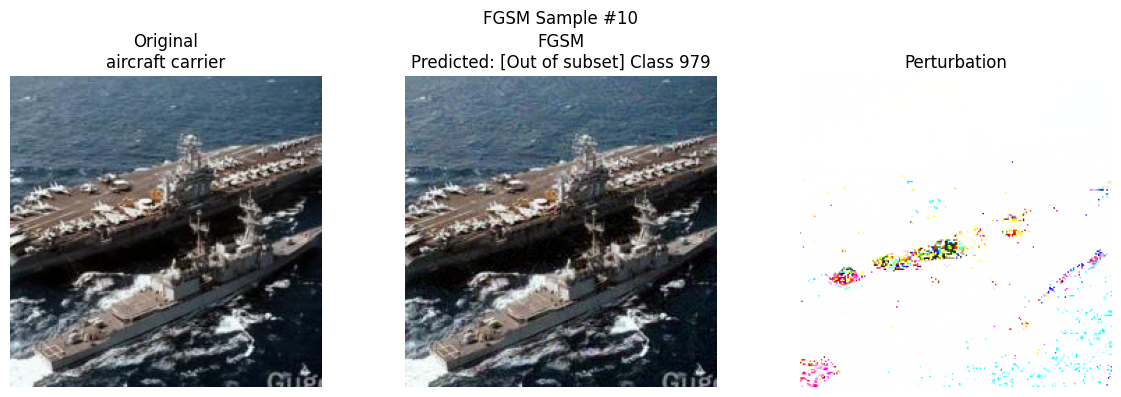

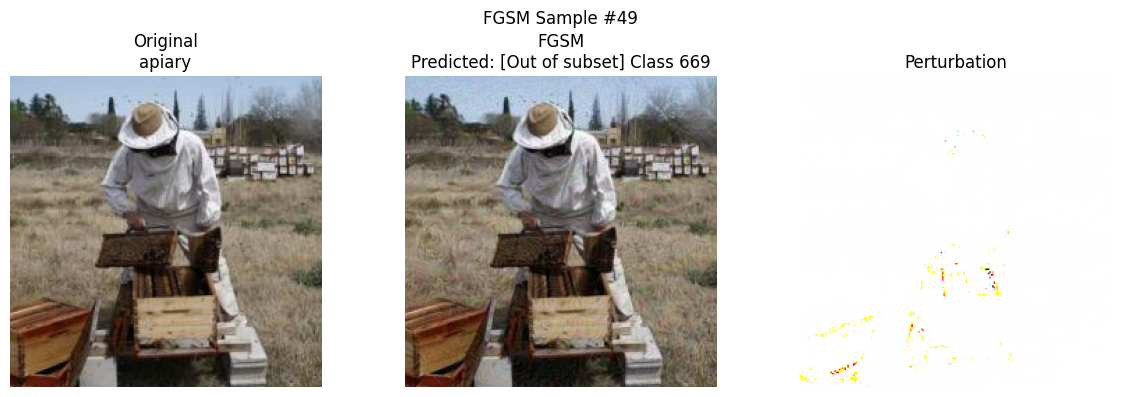

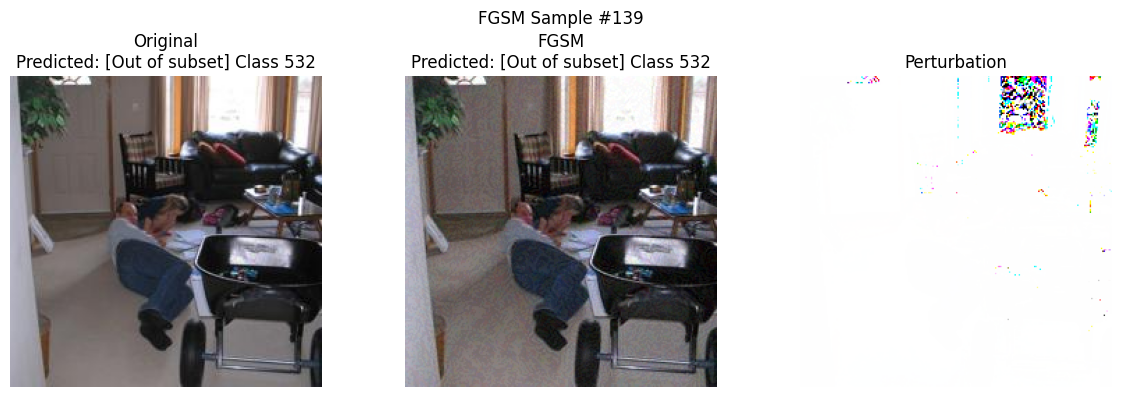

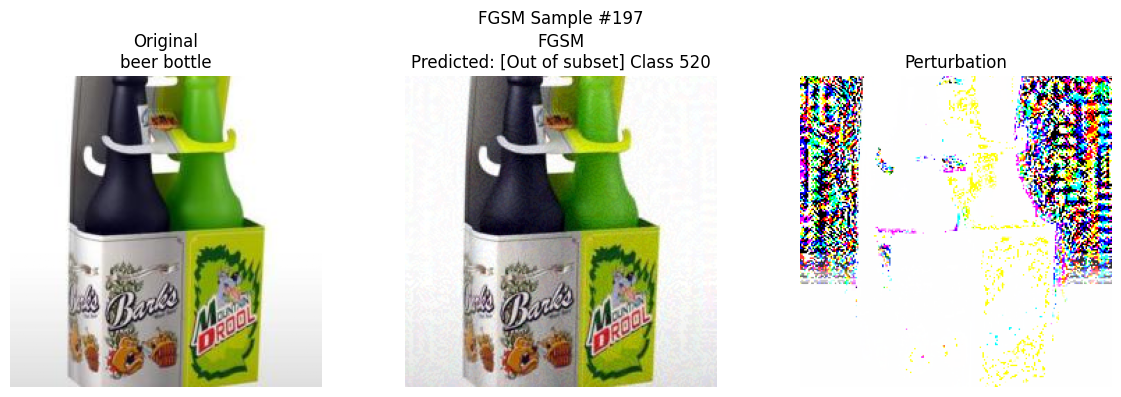

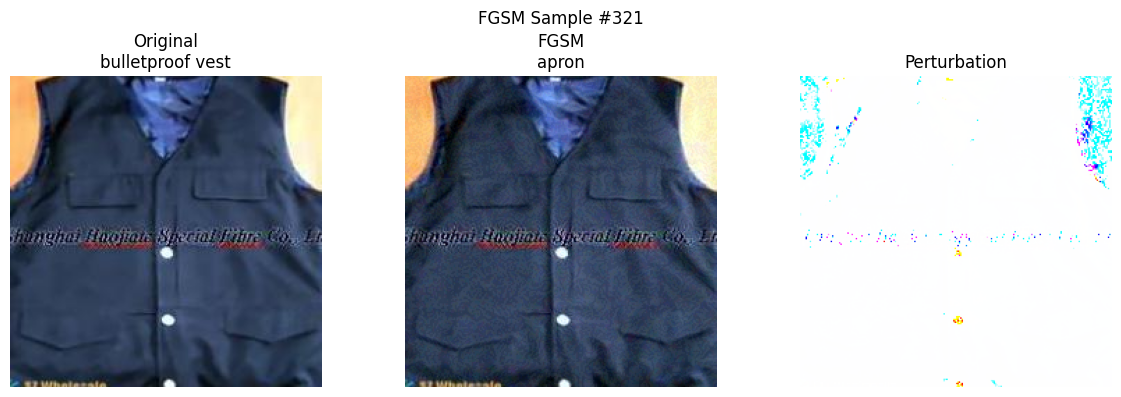

In [ ]:
show_adversarial_comparison(raw_dataset, adv_dataset_images, model, sample_indices, attack_name="FGSM")

## Task3

In [ ]:
def pgd_attack(model, images, labels, epsilon=0.02, alpha=0.005, iters=10):
    ori_images = images.clone().detach().to(device)
    images = ori_images.clone().detach().requires_grad_(True)

    for _ in range(iters):
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        images = images + alpha * images.grad.sign()
        images = torch.max(torch.min(images, ori_images + epsilon), ori_images - epsilon)
        images = torch.clamp(images, 0, 1).detach().requires_grad_(True)

    return images.detach()


In [ ]:
# Generate and evaluate PGD
adv2_images_list, adv2_labels_list = [], []
for images, labels in raw_loader:
    true_labels = torch.tensor([synset_to_idx[raw_dataset.classes[t]] for t in labels]).to(device)
    adv_images = pgd_attack(model, images, true_labels)
    adv2_images_list.append(adv_images.cpu())
    adv2_labels_list.append(true_labels.cpu())

adv2_dataset_images = torch.cat(adv2_images_list)
adv2_dataset_labels = torch.cat(adv2_labels_list)



In [ ]:
# Save
torch.save((adv2_dataset_images, adv2_dataset_labels), "Adversarial_Test_Set_2.pt")

In [ ]:
# Verify L∞ constraint
verify_linf_raw(raw_dataset, adv2_dataset_images, epsilon=0.02, attack_name="PGD")

🔎 PGD - Max L∞ distance: 0.020000
✔️ PGD - ε constraint satisfied



In [ ]:
# Evaluate on PGD Adversarial Dataset
adv2_loader = DataLoader(list(zip(adv2_dataset_images, adv2_dataset_labels)), batch_size=32)
pgd_top1, pgd_top5, total = 0, 0, 0
model.eval()
with torch.no_grad():
    for images, labels in adv2_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, top5_preds = outputs.topk(5, dim=1)
        pgd_top1 += (top5_preds[:, 0] == labels).sum().item()
        pgd_top5 += sum([labels[i].item() in top5_preds[i] for i in range(images.size(0))])
        total += images.size(0)

print(f"⚠️ PGD Top-1 Accuracy: {pgd_top1 / total:.4f}")
print(f"⚠️ PGD Top-5 Accuracy: {pgd_top5 / total:.4f}")

⚠️ PGD Top-1 Accuracy: 0.0000
⚠️ PGD Top-5 Accuracy: 0.0120


## PGD vs Original

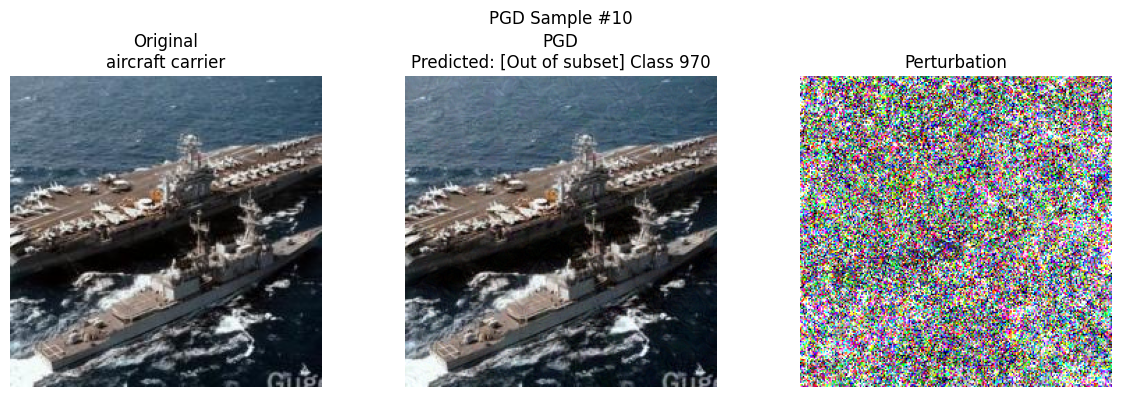

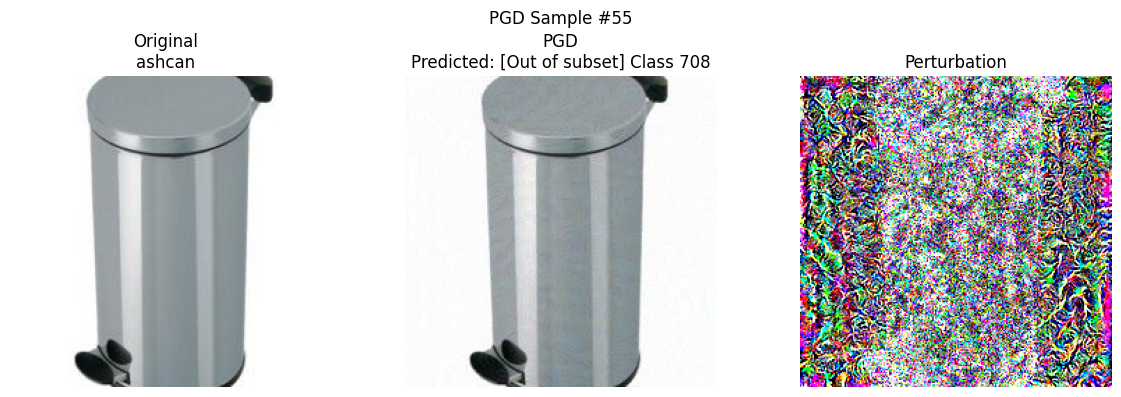

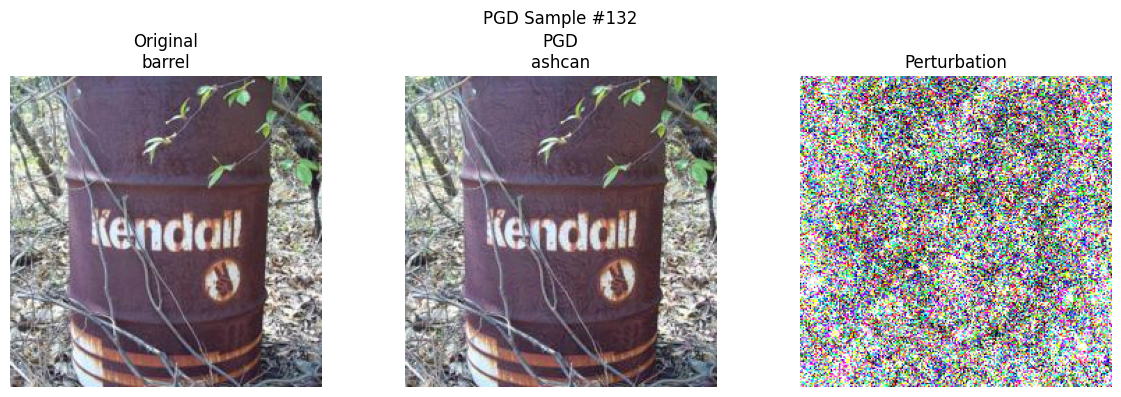

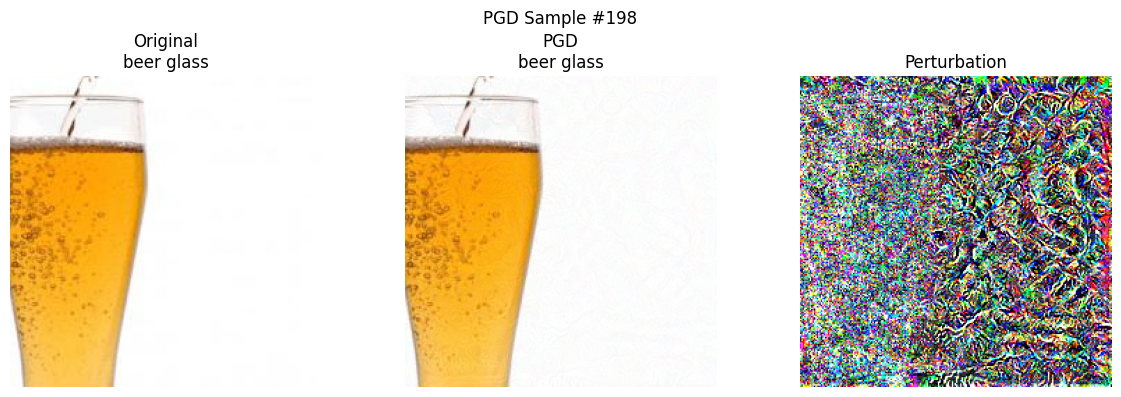

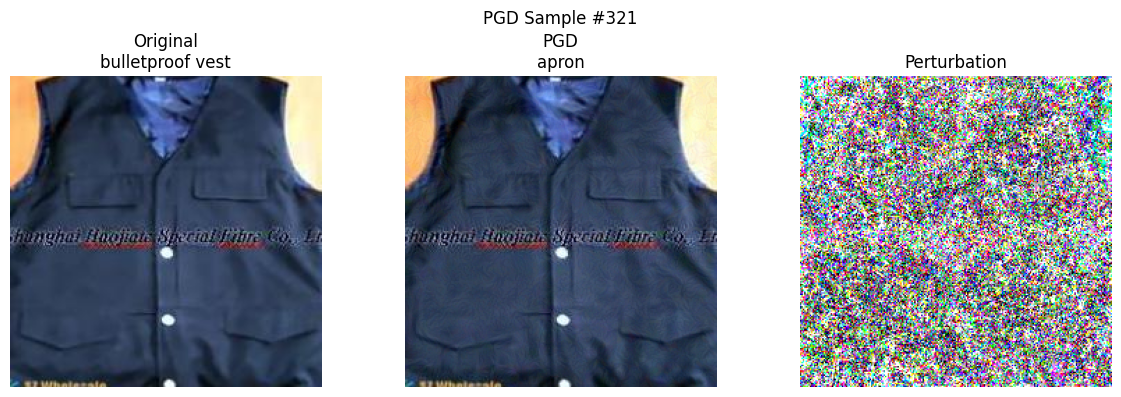

In [ ]:
# Sample indices used for consistent comparison
sample_indices = [10, 55, 132, 198, 321]

show_adversarial_comparison(
    orig_dataset=raw_dataset,
    adv_dataset_images=adv2_dataset_images,
    model=model,
    indices=sample_indices,
    attack_name="PGD"
)


##Task 4

In [ ]:
# === Step 1: Define 32x32 Patch Attack (PGD style) ===
def patch_attack(model, images, labels, epsilon=0.3, alpha=0.03, iters=10, patch_size=32):
    ori_images = images.clone().detach().to(device)
    images = ori_images.clone().detach().requires_grad_(True)
    _, _, H, W = images.shape

    top = torch.randint(0, H - patch_size, (1,)).item()
    left = torch.randint(0, W - patch_size, (1,)).item()

    for _ in range(iters):
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        grad = images.grad
        patch = grad[:, :, top:top+patch_size, left:left+patch_size].sign()
        images.data[:, :, top:top+patch_size, left:left+patch_size] += alpha * patch

        delta = torch.clamp(images - ori_images, -epsilon, epsilon)
        images.data = torch.clamp(ori_images + delta, 0, 1).detach()
        images.requires_grad = True

    return images.detach()


In [ ]:
# === Step 2: Generate Adversarial Test Set 3 ===
adv3_images_list, adv3_labels_list = [], []

for images, labels in raw_loader:
    images = images.to(device)
    true_labels = torch.tensor([synset_to_idx[raw_dataset.classes[t]] for t in labels]).to(device)

    adv_images = patch_attack(model, images, true_labels, epsilon=0.3, alpha=0.03, iters=10)

    adv3_images_list.append(adv_images.cpu())
    adv3_labels_list.append(true_labels.cpu())

adv3_dataset_images = torch.cat(adv3_images_list)
adv3_dataset_labels = torch.cat(adv3_labels_list)

torch.save((adv3_dataset_images, adv3_dataset_labels), "Adversarial_Test_Set_3.pt")


In [ ]:
# === Step 3: Verify L∞ Constraint ===
verify_linf_raw(raw_dataset, adv3_dataset_images, epsilon=0.3, attack_name="Patch Attack")


🔎 Patch Attack - Max L∞ distance: 0.300000
✔️ Patch Attack - ε constraint satisfied



In [ ]:
# === Step 4: Evaluate Accuracy on Adversarial Set 3 ===
adv3_loader = DataLoader(list(zip(adv3_dataset_images, adv3_dataset_labels)), batch_size=32)
patch_top1, patch_top5, total = 0, 0, 0

with torch.no_grad():
    for images, labels in adv3_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, top5_preds = outputs.topk(5, dim=1)

        patch_top1 += (top5_preds[:, 0] == labels).sum().item()
        patch_top5 += sum([labels[i].item() in top5_preds[i] for i in range(images.size(0))])
        total += images.size(0)

patch_top1_acc = patch_top1 / total
patch_top5_acc = patch_top5 / total

print(f"⚠️ Patch Attack Top-1 Accuracy: {patch_top1_acc:.4f}")
print(f"⚠️ Patch Attack Top-5 Accuracy: {patch_top5_acc:.4f}")


⚠️ Patch Attack Top-1 Accuracy: 0.1620
⚠️ Patch Attack Top-5 Accuracy: 0.5000


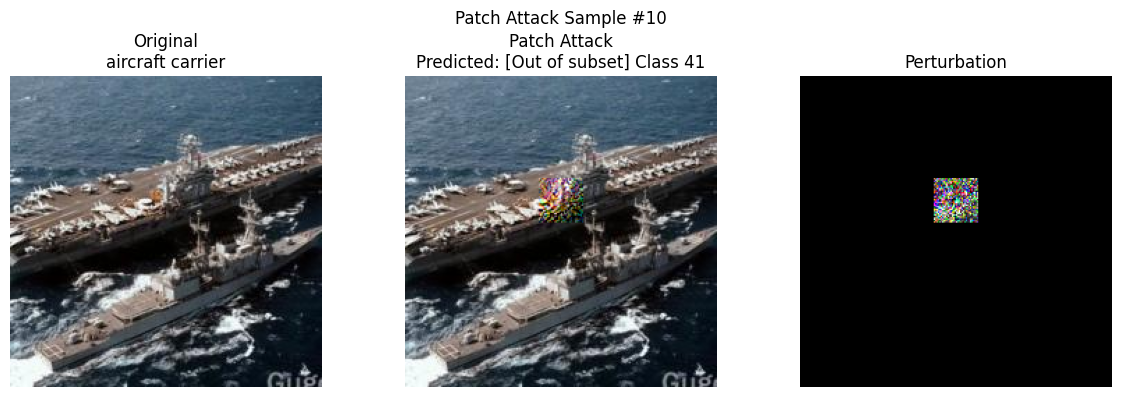

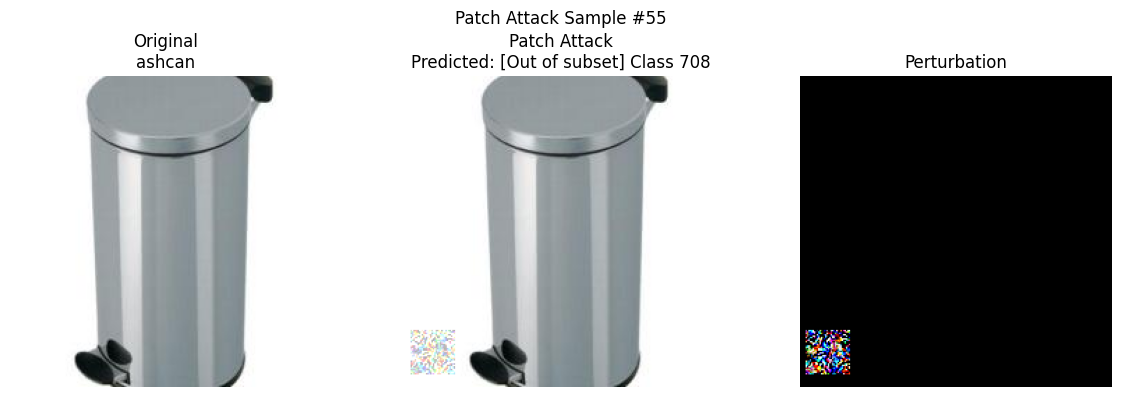

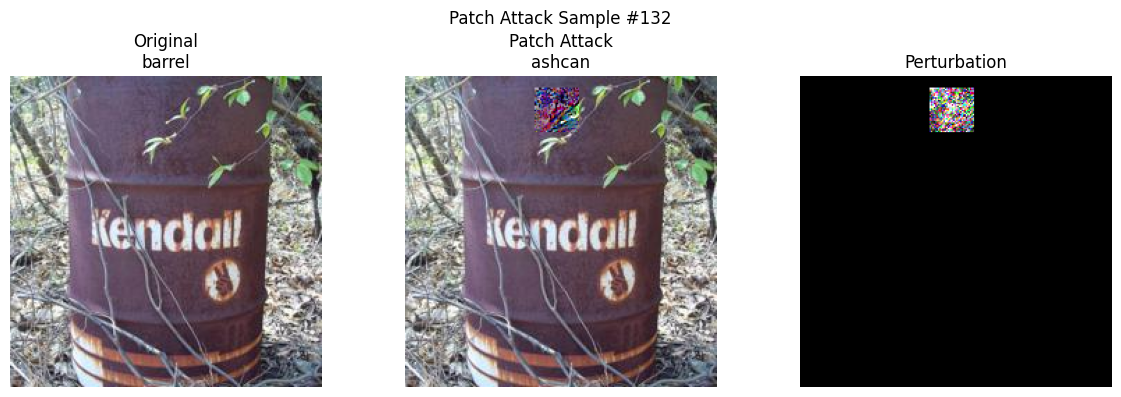

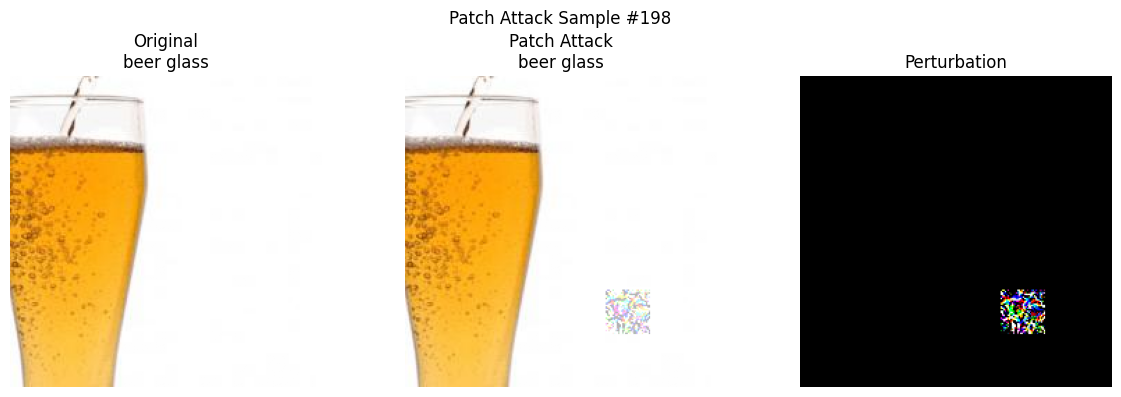

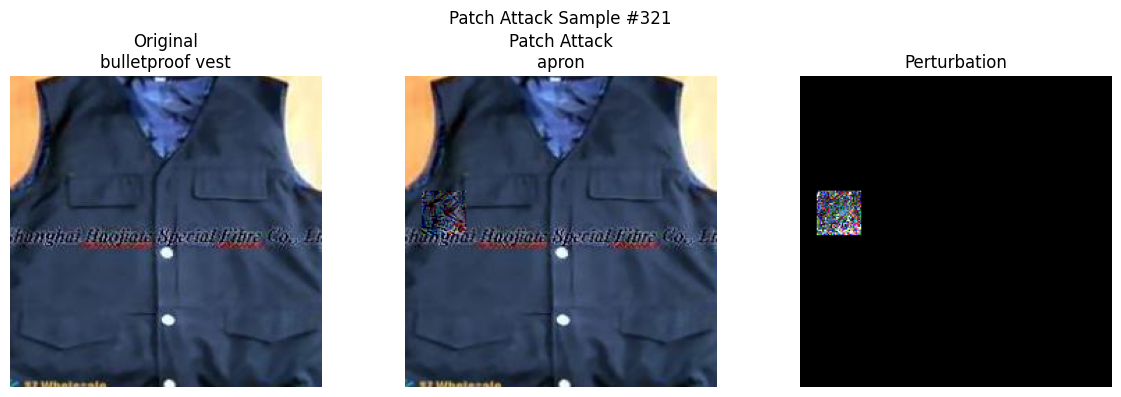

In [ ]:
# === Step 5: Visualize a few patch attack examples ===
sample_indices = [10, 55, 132, 198, 321]
show_adversarial_comparison(
    orig_dataset=raw_dataset,
    adv_dataset_images=adv3_dataset_images,
    model=model,
    indices=sample_indices,
    attack_name="Patch Attack"
)


In [ ]:
# Reuse the normalization values from earlier
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

# Define NormalizedModel wrapper
class NormalizedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.norm = transforms.Normalize(mean=mean_norms, std=std_norms)
    def forward(self, x):
        return self.model(self.norm(x))


## Task 5

In [ ]:
# === Step 1: Load DenseNet-121 for transferability check ===
from torchvision.models import densenet121, DenseNet121_Weights

transfer_model = NormalizedModel(
    densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
).to(device).eval()


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 138MB/s]


In [ ]:
# === Step 2: Prepare original clean dataset tensors ===
original_images = torch.stack([raw_dataset[i][0] for i in range(len(raw_dataset))])
original_labels = torch.tensor([
    synset_to_idx[raw_dataset.classes[raw_dataset[i][1]]] for i in range(len(raw_dataset))
])


In [ ]:
# === Step 3: Load adversarial test sets from disk ===
adv1_images, adv1_labels = torch.load("Adversarial_Test_Set_1.pt")  # FGSM
adv2_images, adv2_labels = torch.load("Adversarial_Test_Set_2.pt")  # PGD
adv3_images, adv3_labels = torch.load("Adversarial_Test_Set_3.pt")  # Patch


In [ ]:
# Evaluation function for top-1 and top-5 accuracy
def evaluate_model(model, image_tensor, label_tensor, name="Set"):
    loader = DataLoader(list(zip(image_tensor, label_tensor)), batch_size=32)
    top1, top5, total = 0, 0, 0

    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, top5_preds = outputs.topk(5, dim=1)
            top1 += (top5_preds[:, 0] == labels).sum().item()
            top5 += sum([labels[i].item() in top5_preds[i] for i in range(images.size(0))])
            total += images.size(0)

    top1_acc = top1 / total
    top5_acc = top5 / total
    print(f"{name} → Top-1: {top1_acc:.4f}, Top-5: {top5_acc:.4f}")
    return top1_acc, top5_acc


In [ ]:
# === Step 4: Evaluate each dataset on the transfer model ===
evaluate_model(transfer_model, original_images, original_labels, name="Clean Set")
evaluate_model(transfer_model, adv1_images, adv1_labels, name="FGSM Set")
evaluate_model(transfer_model, adv2_images, adv2_labels, name="PGD Set")
evaluate_model(transfer_model, adv3_images, adv3_labels, name="Patch Set")


Clean Set → Top-1: 0.7480, Top-5: 0.9360
FGSM Set → Top-1: 0.4880, Top-5: 0.7780
PGD Set → Top-1: 0.4920, Top-5: 0.7940
Patch Set → Top-1: 0.7120, Top-5: 0.9080


(0.712, 0.908)

### 📊 Accuracy Comparison Before Transfer (Evaluated on ResNet-34)

| Dataset              | Model     | Top-1 Accuracy | Top-5 Accuracy |
|----------------------|-----------|----------------|----------------|
| Original             | ResNet-34 | 0.7600         | 0.9420         |
| FGSM Attack          | ResNet-34 | 0.2640         | 0.5060         |
| PGD Attack           | ResNet-34 | 0.0040         | 0.0640         |
| Patch Attack         | ResNet-34 | 0.1620         | 0.5000         |

---

### 🔁 Transferability Evaluation (Evaluated on DenseNet-121)

| Dataset              | Model        | Top-1 Accuracy | Top-5 Accuracy |
|----------------------|--------------|----------------|----------------|
| Original             | DenseNet-121 | 0.7480         | 0.9360         |
| FGSM Attack          | DenseNet-121 | 0.4880         | 0.7780         |
| PGD Attack           | DenseNet-121 | 0.4920         | 0.7940         |
| Patch Attack         | DenseNet-121 | 0.7120         | 0.9080         |

---

### 🔍 Observations & Discussion

- **All adversarial attacks caused significant drops in accuracy on the original ResNet-34 model**, with PGD showing the most aggressive degradation (Top-1: 0.0040).
- **When transferred to DenseNet-121**, the attacks remained partially effective, demonstrating strong **cross-model transferability**, especially FGSM and PGD.
- **Patch-based attacks were more localized** and had weaker transferability. DenseNet-121 still achieved high Top-1 accuracy of 0.7120 on the patch set.
- This illustrates that **perturbations which exploit global gradients (FGSM/PGD)** are more generalizable across models, while **localized patches are more model-specific**.

---

### 🛡️ Lessons & Mitigation Strategies

- Transferability highlights a serious risk in real-world systems — an attacker doesn’t need access to your exact model.
- Defensive approaches like **adversarial training**, **input randomization**, and **gradient masking** can help reduce effectiveness of transferable attacks.
- Future work can explore **certified defenses** and **ensemble models** to further improve robustness.
